In [1]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, isnull, avg, date_format, min
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType
from pyspark.ml.stat import Summarizer
from pyspark import pandas as ps
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import numpy as np

/home/spark_user/spark/python/pyspark/pandas/__init__.py:49: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [2]:
spark = SparkSession.builder \
    .master('spark://spark-master:7077') \
    .appName('W4M2') \
    .config('spark.executor.memory', '12gb') \
    .config("spark.executor.cores", "5") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/08/03 14:06:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# 1. Data Loading
- Load the TLC Trip Record Data into a Spark DataFrame

In [3]:
df = spark.read.parquet('hdfs://spark-master:9000/user/hduser/hdfs_data/fhvhv_tripdata_2023-01.parquet')
df.show(1, vertical=True)

-RECORD 0-----------------------------------
 hvfhs_license_num    | HV0003              
 dispatching_base_num | B03404              
 originating_base_num | B03404              
 request_datetime     | 2023-01-01 00:18:06 
 on_scene_datetime    | 2023-01-01 00:19:24 
 pickup_datetime      | 2023-01-01 00:19:38 
 dropoff_datetime     | 2023-01-01 00:48:07 
 PULocationID         | 48                  
 DOLocationID         | 68                  
 trip_miles           | 0.94                
 trip_time            | 1709                
 base_passenger_fare  | 25.95               
 tolls                | 0.0                 
 bcf                  | 0.78                
 sales_tax            | 2.3                 
 congestion_surcharge | 2.75                
 airport_fee          | 0.0                 
 tips                 | 5.22                
 driver_pay           | 27.83               
 shared_request_flag  | N                   
 shared_match_flag    | N                   
 access_a_

# 2. Data Cleaning
## 2.1. Handle missing values by either removing or imputing them.

Before data cleaning

In [4]:
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show(vertical=True)

-RECORD 0-----------------------
 hvfhs_license_num    | 0       
 dispatching_base_num | 0       
 originating_base_num | 4891992 
 request_datetime     | 0       
 on_scene_datetime    | 4891992 
 pickup_datetime      | 0       
 dropoff_datetime     | 0       
 PULocationID         | 0       
 DOLocationID         | 0       
 trip_miles           | 0       
 trip_time            | 0       
 base_passenger_fare  | 0       
 tolls                | 0       
 bcf                  | 0       
 sales_tax            | 0       
 congestion_surcharge | 0       
 airport_fee          | 0       
 tips                 | 0       
 driver_pay           | 0       
 shared_request_flag  | 0       
 shared_match_flag    | 0       
 access_a_ride_flag   | 0       
 wav_request_flag     | 0       
 wav_match_flag       | 0       



remove null value

In [5]:
df = df.na.drop('any')

After data cleaning

In [6]:
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show(vertical=True)

-RECORD 0-------------------
 hvfhs_license_num    | 0   
 dispatching_base_num | 0   
 originating_base_num | 0   
 request_datetime     | 0   
 on_scene_datetime    | 0   
 pickup_datetime      | 0   
 dropoff_datetime     | 0   
 PULocationID         | 0   
 DOLocationID         | 0   
 trip_miles           | 0   
 trip_time            | 0   
 base_passenger_fare  | 0   
 tolls                | 0   
 bcf                  | 0   
 sales_tax            | 0   
 congestion_surcharge | 0   
 airport_fee          | 0   
 tips                 | 0   
 driver_pay           | 0   
 shared_request_flag  | 0   
 shared_match_flag    | 0   
 access_a_ride_flag   | 0   
 wav_request_flag     | 0   
 wav_match_flag       | 0   



## 2.2 Convert all relevant time fields to a standard timestamp format.

In [7]:
df = df.withColumn("request_datetime", date_format(df.request_datetime,'yyyy-MM-dd HH:mm:ss'))
df = df.withColumn("on_scene_datetime", date_format(df.on_scene_datetime,'yyyy-MM-dd HH:mm:ss'))
df = df.withColumn("pickup_datetime", date_format(df.pickup_datetime,'yyyy-MM-dd HH:mm:ss'))
df = df.withColumn("dropoff_datetime", date_format(df.dropoff_datetime,'yyyy-MM-dd HH:mm:ss'))

## 2.3. Filter out records with non-sensical values (e.g., negative trip duration or distance).
- df.describe method를 이용하여 min, max 값 확인 결과, base_passenger_fare와 driver_pay에 음수 값이 있다는 것 확인
- 비용이 음수인 경우는 일반적인 상황이 아니라고 가정하고, 해당 주행 정보(row) 전체를 drop 함.

In [8]:
df.describe(df.columns).show(vertical=True)

-RECORD 0-----------------------------------
 summary              | count               
 hvfhs_license_num    | 13587039            
 dispatching_base_num | 13587039            
 originating_base_num | 13587039            
 request_datetime     | 13587039            
 on_scene_datetime    | 13587039            
 pickup_datetime      | 13587039            
 dropoff_datetime     | 13587039            
 PULocationID         | 13587039            
 DOLocationID         | 13587039            
 trip_miles           | 13587039            
 trip_time            | 13587039            
 base_passenger_fare  | 13587039            
 tolls                | 13587039            
 bcf                  | 13587039            
 sales_tax            | 13587039            
 congestion_surcharge | 13587039            
 airport_fee          | 13587039            
 tips                 | 13587039            
 driver_pay           | 13587039            
 shared_request_flag  | 13587039            
 shared_ma

In [9]:
df = df.filter(df.driver_pay > 0)
df = df.filter(df.base_passenger_fare > 0)

In [10]:
df.describe(df.columns).show(vertical=True)

-RECORD 0-----------------------------------
 summary              | count               
 hvfhs_license_num    | 13547940            
 dispatching_base_num | 13547940            
 originating_base_num | 13547940            
 request_datetime     | 13547940            
 on_scene_datetime    | 13547940            
 pickup_datetime      | 13547940            
 dropoff_datetime     | 13547940            
 PULocationID         | 13547940            
 DOLocationID         | 13547940            
 trip_miles           | 13547940            
 trip_time            | 13547940            
 base_passenger_fare  | 13547940            
 tolls                | 13547940            
 bcf                  | 13547940            
 sales_tax            | 13547940            
 congestion_surcharge | 13547940            
 airport_fee          | 13547940            
 tips                 | 13547940            
 driver_pay           | 13547940            
 shared_request_flag  | 13547940            
 shared_ma

# Calculation of Metrics
- Compute the average duration of trips.

In [11]:
avg_duration = df.select(avg(df.trip_time).alias("average trip time (s)"))
avg_duration.coalesce(1).write.csv("hdfs://spark-master:9000/user/spark_user/W4M2_output/avg_duration.csv")
avg_duration.show()

+---------------------+
|average trip time (s)|
+---------------------+
|    1101.164382038893|
+---------------------+



- Compute the average distance of trips.

In [12]:
avg_distance = df.select(avg(df.trip_miles).alias("average trip distance (miles)"))
avg_distance.coalesce(1).write.csv("hdfs://spark-master:9000/user/spark_user/W4M2_output/avg_distance.csv")
avg_distance.show()

+-----------------------------+
|average trip distance (miles)|
+-----------------------------+
|            4.924506504235864|
+-----------------------------+



# Peak Hours Identification
Identify the peak hours for taxi usage.

1. Add column for 'hour' info.

In [13]:
df = df.withColumn("hour", date_format(df.request_datetime,'H'))
df = df.withColumn("hour", df['hour'].cast(IntegerType()))

2. Casting hour column(str to int)

In [14]:
df_hour = df.groupBy("hour").count()
df_hour.orderBy("hour").show(df.count())

+----+------+
|hour| count|
+----+------+
|   0|473350|
|   1|342571|
|   2|255896|
|   3|206243|
|   4|185852|
|   5|217027|
|   6|351828|
|   7|546642|
|   8|654781|
|   9|594321|
|  10|556871|
|  11|563399|
|  12|584507|
|  13|618021|
|  14|681338|
|  15|696678|
|  16|723156|
|  17|822859|
|  18|868174|
|  19|835663|
|  20|748916|
|  21|721523|
|  22|695329|
|  23|602995|
+----+------+



In [15]:
ps_df_hour = ps.DataFrame(df_hour)
np_hour_cnt = ps_df_hour.to_numpy()
hour_cnt = list(map(list, np_hour_cnt))
hour_cnt = sorted(hour_cnt, key=lambda x:x[0]) 
hour_cnt = np.array(hour_cnt)

/home/spark_user/spark/python/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


/tmp/ipykernel_46367/1753285871.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  colors[int(max_idx[0])] = 'skyblue'


Text(0.5, 1.0, 'Peak Hours Identification')

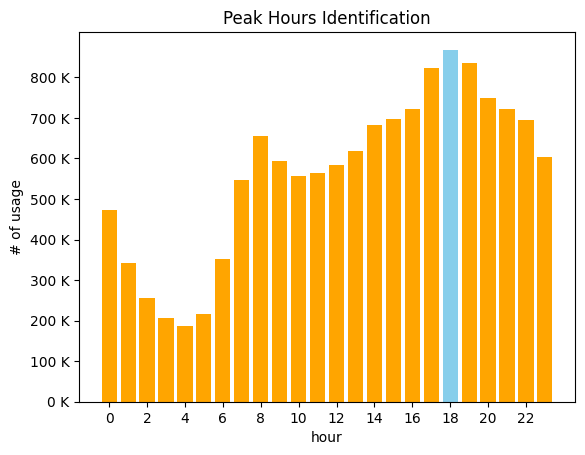

In [16]:
max_cnt = np_hour_cnt[:,1].max()
max_idx = np.where(hour_cnt==max_cnt)

colors = ['orange' for _ in range(24)]
colors[int(max_idx[0])] = 'skyblue'
plt.bar(hour_cnt[:,0], hour_cnt[:,1], color=colors)
plt.xlabel("hour")
plt.ylabel("# of usage")
plt.xticks([x for x in range(0, 24, 2)])
y_interval = 100000
y_ticks_str = [str(round(x/1000))+' K' for x in range(0, max_cnt, y_interval)]
plt.yticks([y for y in range(0, max_cnt, y_interval)], y_ticks_str)

plt.title("Peak Hours Identification")

# Weather Condition Analysis
- Load weather dataset

In [17]:
weather_df = spark.read.csv('hdfs://spark-master:9000/user/hduser/hdfs_data/72505394728.csv')

In [18]:
first_row = weather_df.first()
columns = [str(cell) for cell in first_row]

weather_df = weather_df.filter(weather_df['_c0'] != first_row[0])
weather_df = weather_df.toDF(*columns)

24/08/03 14:51:41 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [19]:
not_use_cols = ['NAME', 'REPORT_TYPE', 'CALL_SIGN', 'QUALITY_CONTROL', 'CIG', 'VIS', 'DEW', 'SLP', 'AA2', 'AA3', 'AB1', 'AD1', 'AE1', 'AH1', 'AH2', 'AH3', 
                'AH4', 'AH5', 'AH6', 'AI1', 'AI2', 'AI3', 'AI4', 'AI5', 'AI6', 'AJ1', 'AK1', 'AL1', 'AM1', 'AN1', 'AT1', 'AT2', 'AT3', 'AT4', 'AT5', 'AU1',
                'AU2', 'AW1', 'AW2', 'AW3', 'AX1', 'AX2', 'AX3', 'AX4', 'GA1', 'GA2', 'GA3', 'GD1', 'GD2', 'GD3', 'GE1', 'GF1', 'KA1', 'KA2', 'KB1', 'KB2',
                'KB3', 'KC1', 'KC2', 'KD1', 'KD2', 'KE1', 'KG1', 'KG2', 'MA1', 'MD1', 'MF1', 'MG1', 'MH1', 'MK1', 'MW1', 'OC1', 'OD1', 'OE1', 'OE2', 'OE3',
                'RH1', 'RH2', 'RH3', 'WA1', 'REM', 'EQD', 'SOURCE', 'LATITUDE', 'LONGITUDE', 'ELEVATION']

In [20]:
for col_name in not_use_cols:
    weather_df = weather_df.drop(col_name)

In [21]:
weather_df = weather_df.withColumn('Temperature(C)', F.regexp_extract('TMP', r'(\+|-)?\d{4}', 0).cast('int') / 10) # 섭씨 온도
weather_df = weather_df.withColumn('Wind_Power(m/s)', F.regexp_extract('WND', r'\d{3},\d,[A-Z],(\d{4})', 1).cast('int') / 10) # 풍속

In [22]:
# UTC => 실제 뉴욕 시간으로 변경
weather_df = weather_df.withColumn('DATE', F.col('DATE').cast('timestamp'))
weather_df = weather_df.withColumn('DATE', F.col('DATE') - F.expr('INTERVAL 4 HOURS'))

In [23]:
# 강수량 전처리
weather_df = weather_df.withColumn('RAIN_PER_HOUR', F.regexp_extract('AA1', r'\d{2},(\d{4})', 1).cast('int') / 10) # 강수량

In [24]:
# 일별 시간대 컬럼 추가
weather_df = weather_df.withColumn('DAY', F.dayofmonth(F.col('DATE')))
weather_df = weather_df.withColumn('HOUR', F.hour(F.col('DATE')))
weather_df = weather_df.withColumn('MONTH', F.month(F.col('DATE'))) 
weather_df = weather_df.withColumn('Year', F.year(F.col('DATE')))

In [25]:
# DATE가 동일한 컬럼 제거
print("Before count:", weather_df.count())
weather_df = weather_df.dropDuplicates(['DATE'])
print("After count:", weather_df.count())

Before count: 11842
After count: 11824


In [26]:
# temperature 결측치 처리
weather_df = weather_df.withColumn('Temperature(C)', F.when(F.col('Temperature(C)') == 999.9, None).otherwise(F.col('Temperature(C)')))
window_spec = Window.partitionBy('STATION').orderBy('DATE').rowsBetween(-3, 3)
weather_df = weather_df.withColumn('Temperature(C)', F.when(F.col('Temperature(C)').isNull(), F.avg('Temperature(C)').over(window_spec)).otherwise(F.col('Temperature(C)')))

In [27]:
# wind_power 결측치 처리
ndf = weather_df.withColumn('Wind_Power(m/s)', F.when(F.col('Wind_Power(m/s)') == 999.9, None).otherwise(F.col('Wind_Power(m/s)')))
window_spec = Window.partitionBy('STATION').orderBy('DATE').rowsBetween(-3, 3)
ndf = weather_df.withColumn('Wind_Power(m/s)', F.when(F.col('Wind_Power(m/s)').isNull(), F.avg('Wind_Power(m/s)').over(window_spec)).otherwise(F.col('Wind_Power(m/s)')))

In [28]:
# RAIN_PER_HOUR
weather_df = weather_df.withColumn('RAIN_PER_HOUR', F.when(F.col('RAIN_PER_HOUR') == 999.9, None).otherwise(F.col('RAIN_PER_HOUR')))
window_spec = Window.partitionBy('STATION').orderBy('DATE').rowsBetween(-3, 3)
weather_df = weather_df.withColumn('RAIN_PER_HOUR', F.when(F.col('RAIN_PER_HOUR').isNull(), F.avg('RAIN_PER_HOUR').over(window_spec)).otherwise(F.col('RAIN_PER_HOUR')))

In [29]:
weather_df.show(1, vertical=True)

-RECORD 0------------------------------
 STATION         | 72505394728         
 DATE            | 2022-12-31 20:06:00 
 WND             | 999,9,C,0000,5      
 TMP             | +0100,5             
 AA1             | 01,0000,2,1         
 Temperature(C)  | 10.0                
 Wind_Power(m/s) | 0.0                 
 RAIN_PER_HOUR   | 0.0                 
 DAY             | 31                  
 HOUR            | 20                  
 MONTH           | 12                  
 Year            | 2022                
only showing top 1 row



In [30]:
weather_df.describe(weather_df.columns).show(vertical=True)

-RECORD 0-------------------------------
 summary         | count                
 STATION         | 11824                
 WND             | 11824                
 TMP             | 11824                
 AA1             | 10361                
 Temperature(C)  | 11824                
 Wind_Power(m/s) | 11433                
 RAIN_PER_HOUR   | 11769                
 DAY             | 11824                
 HOUR            | 11824                
 MONTH           | 11824                
 Year            | 11824                
-RECORD 1-------------------------------
 summary         | mean                 
 STATION         | 7.2505394728E10      
 WND             | null                 
 TMP             | null                 
 AA1             | null                 
 Temperature(C)  | 14.384788001804344   
 Wind_Power(m/s) | 48.774626082387876   
 RAIN_PER_HOUR   | 0.506257116152604    
 DAY             | 16.073663734776726   
 HOUR            | 11.00862652232747    
 MONTH          

In [31]:
weather_df = weather_df.withColumn("TARGET", date_format(weather_df.DATE,'yyyy-MM-dd H'))
weather_df = weather_df.select('DATE', 'TMP', 'WND', 'TARGET', 'AA1', 'Temperature(C)', 'Wind_Power(m/s)', 'RAIN_PER_HOUR')
weather_df = weather_df.groupBy('DATE',"TARGET").avg()
weather_df = weather_df.orderBy('DATE')

In [32]:
weather_df.show(20)

+-------------------+-------------+-------------------+--------------------+------------------+
|               DATE|       TARGET|avg(Temperature(C))|avg(Wind_Power(m/s))|avg(RAIN_PER_HOUR)|
+-------------------+-------------+-------------------+--------------------+------------------+
|2022-12-31 20:06:00|2022-12-31 20|               10.0|                 0.0|               0.0|
|2022-12-31 20:18:00|2022-12-31 20|               10.0|                 1.5|               0.0|
|2022-12-31 20:31:00|2022-12-31 20|               10.0|                 0.0|               0.2|
|2022-12-31 20:44:00|2022-12-31 20|               10.0|                 0.0|               0.5|
|2022-12-31 20:49:00|2022-12-31 20|               10.0|                 0.0|0.4166666666666667|
|2022-12-31 20:51:00|2022-12-31 20|               10.0|                 0.0|               0.8|
|2022-12-31 21:19:00|2022-12-31 21|               10.6|                 0.0|               0.5|
|2022-12-31 21:27:00|2022-12-31 21|     

In [33]:
df = df.withColumn("TARGET", date_format(df.request_datetime,'yyyy-MM-dd H'))
df.show(1, vertical=True)

-RECORD 0-----------------------------------
 hvfhs_license_num    | HV0003              
 dispatching_base_num | B03404              
 originating_base_num | B03404              
 request_datetime     | 2023-01-01 00:18:06 
 on_scene_datetime    | 2023-01-01 00:19:24 
 pickup_datetime      | 2023-01-01 00:19:38 
 dropoff_datetime     | 2023-01-01 00:48:07 
 PULocationID         | 48                  
 DOLocationID         | 68                  
 trip_miles           | 0.94                
 trip_time            | 1709                
 base_passenger_fare  | 25.95               
 tolls                | 0.0                 
 bcf                  | 0.78                
 sales_tax            | 2.3                 
 congestion_surcharge | 2.75                
 airport_fee          | 0.0                 
 tips                 | 5.22                
 driver_pay           | 27.83               
 shared_request_flag  | N                   
 shared_match_flag    | N                   
 access_a_

### The average number of calls depending on whether it rains
- To represent the presence of rain as a binary variable, it is considered to have rained if the average hourly precipitation is 1mm or more.

In [34]:
# Join weather info with TLC dataset
df_w_weather = df.join(weather_df, df.TARGET==weather_df.TARGET, 'inner')
df_w_weather = df_w_weather.drop(df.TARGET)
df_w_weather.show(1, vertical=True)

-RECORD 0-----------------------------------
 hvfhs_license_num    | HV0003              
 dispatching_base_num | B03404              
 originating_base_num | B03404              
 request_datetime     | 2023-01-01 00:18:06 
 on_scene_datetime    | 2023-01-01 00:19:24 
 pickup_datetime      | 2023-01-01 00:19:38 
 dropoff_datetime     | 2023-01-01 00:48:07 
 PULocationID         | 48                  
 DOLocationID         | 68                  
 trip_miles           | 0.94                
 trip_time            | 1709                
 base_passenger_fare  | 25.95               
 tolls                | 0.0                 
 bcf                  | 0.78                
 sales_tax            | 2.3                 
 congestion_surcharge | 2.75                
 airport_fee          | 0.0                 
 tips                 | 5.22                
 driver_pay           | 27.83               
 shared_request_flag  | N                   
 shared_match_flag    | N                   
 access_a_

In [35]:
df.show(1, vertical=True)

-RECORD 0-----------------------------------
 hvfhs_license_num    | HV0003              
 dispatching_base_num | B03404              
 originating_base_num | B03404              
 request_datetime     | 2023-01-01 00:18:06 
 on_scene_datetime    | 2023-01-01 00:19:24 
 pickup_datetime      | 2023-01-01 00:19:38 
 dropoff_datetime     | 2023-01-01 00:48:07 
 PULocationID         | 48                  
 DOLocationID         | 68                  
 trip_miles           | 0.94                
 trip_time            | 1709                
 base_passenger_fare  | 25.95               
 tolls                | 0.0                 
 bcf                  | 0.78                
 sales_tax            | 2.3                 
 congestion_surcharge | 2.75                
 airport_fee          | 0.0                 
 tips                 | 5.22                
 driver_pay           | 27.83               
 shared_request_flag  | N                   
 shared_match_flag    | N                   
 access_a_

In [36]:
df = df_w_weather
df = df.na.drop('any')
df = df.withColumn("is_rainy", df['avg(RAIN_PER_HOUR)'] > 1)
df = df.withColumn("is_weekend", date_format("request_datetime", 'EEE').isin(["Sat", "Sun"]).cast("int"))
df = df.withColumn("DAY", date_format(df.request_datetime,'dd'))
df.show(1, vertical=True)

-RECORD 0-----------------------------------
 hvfhs_license_num    | HV0003              
 dispatching_base_num | B03404              
 originating_base_num | B03404              
 request_datetime     | 2023-01-01 00:18:06 
 on_scene_datetime    | 2023-01-01 00:19:24 
 pickup_datetime      | 2023-01-01 00:19:38 
 dropoff_datetime     | 2023-01-01 00:48:07 
 PULocationID         | 48                  
 DOLocationID         | 68                  
 trip_miles           | 0.94                
 trip_time            | 1709                
 base_passenger_fare  | 25.95               
 tolls                | 0.0                 
 bcf                  | 0.78                
 sales_tax            | 2.3                 
 congestion_surcharge | 2.75                
 airport_fee          | 0.0                 
 tips                 | 5.22                
 driver_pay           | 27.83               
 shared_request_flag  | N                   
 shared_match_flag    | N                   
 access_a_

In [37]:
total_call_rainy = df.filter(df.is_rainy=='true').count()
rainy_time_slot = df.filter(df.is_rainy=='true').select('request_datetime', 'hour').distinct().count()
avg_call_rainy = total_call_rainy / rainy_time_slot

total_call_sunny = df.filter(df.is_rainy=='false').count()
sunny_time_slot = df.filter(df.is_rainy=='false').select('request_datetime', 'hour').distinct().count()
avg_call_sunny = total_call_sunny / sunny_time_slot

Text(0.5, 1.0, 'Average call per hour')

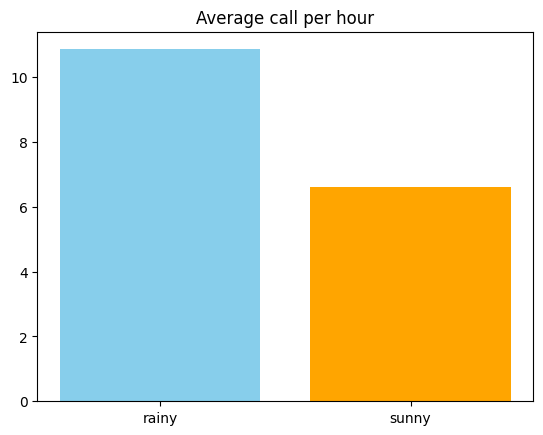

In [38]:
plt.bar(['rainy', 'sunny'], [avg_call_rainy, avg_call_sunny], color=['skyblue','orange'])
plt.title('Average call per hour')

# Save DataFrame

In [39]:
df.write.coalesce(1).csv("hdfs://spark-master:9000/user/spark_user/W4M2_output/TLC_dataframe.csv")

# Side Project: WAV TARGET

In [40]:
wav_df = df.filter(df.wav_request_flag=='Y')

## 1. Weekend/weekdays Identification

In [41]:
per_day_df = df.select('DAY','is_weekend').groupBy('DAY', 'is_weekend').count().orderBy('DAY')
wav_per_day_df = wav_df.select('DAY','is_weekend').groupBy('DAY', 'is_weekend').count().orderBy('DAY')

/home/spark_user/spark/python/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/home/spark_user/spark/python/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


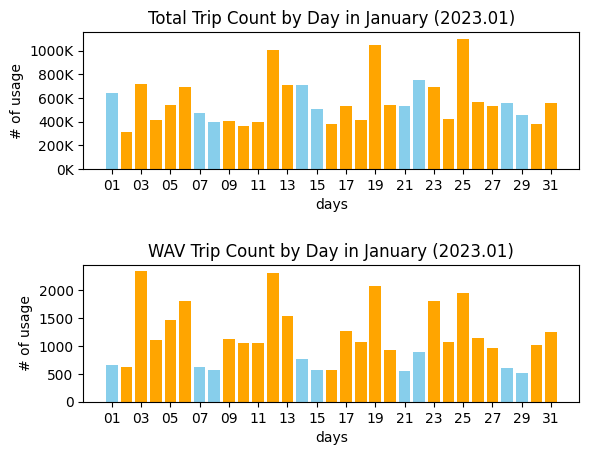

In [45]:
datas = [per_day_df, wav_per_day_df]
titles = ["Total Trip Count by Day in January (2023.01)", "WAV Trip Count by Day in January (2023.01)"]
intervals = [200000, 500]

for i in range(2):
    data_df = ps.DataFrame(datas[i])
    np_data = data_df.to_numpy()
    days = list(np_data[:,0])
    is_weekend = list(np_data[:,1])
    cnt = list(np_data[:,2])
    max_cnt = int(max(cnt))
    colors = ['orange' for _ in range(len(days))]
    for j in range(len(days)):
        if is_weekend[j] == 1:
            colors[j] = 'skyblue'
    plt.subplot(2, 1, i+1) 
    plt.bar(days, cnt, color=colors)
    plt.xlabel("days")
    plt.ylabel("# of usage")
    plt.xticks([x for x in range(0, 31, 2)])
    y_interval = intervals[i]
    if y_interval > 1000:
        y_ticks_str = [str(x//1000)+ "K" for x in range(0, max_cnt, y_interval)]
    else:
        y_ticks_str = [str(x) for x in range(0, max_cnt, y_interval)]
    plt.yticks([y for y in range(0, max_cnt, y_interval)], y_ticks_str)
    plt.title(titles[i])

plt.subplots_adjust(hspace=0.7)
plt.show()

In [43]:
df_weekend = df.filter(df.is_weekend==1)
df_weekend_gb = df_weekend.groupBy('hour').count().orderBy('hour')
df_weekend_gb = df_weekend_gb.withColumn("avg_cnt", df_weekend_gb['count'] / df_weekend.select('DAY').distinct().count())

df_weekdays = df.filter(wav_df.is_weekend==0)
df_weekdays_gb = df_weekdays.groupBy('hour').count().orderBy('hour')
df_weekdays_gb = df_weekdays_gb.withColumn("avg_cnt", df_weekdays_gb['count'] / df_weekdays.select('DAY').distinct().count())

wav_df_weekend = wav_df.filter(wav_df.is_weekend==1)
wav_df_weekend_gb = wav_df_weekend.groupBy('hour').count().orderBy('hour')
wav_df_weekend_gb = wav_df_weekend_gb.withColumn("avg_cnt", wav_df_weekend_gb['count'] / wav_df_weekend.select('DAY').distinct().count())

wav_df_weekdays = wav_df.filter(wav_df.is_weekend==0)
wav_df_weekdays_gb = wav_df_weekdays.groupBy('hour').count().orderBy('hour')
wav_df_weekdays_gb = wav_df_weekdays_gb.withColumn("avg_cnt", wav_df_weekdays_gb['count'] / wav_df_weekdays.select('DAY').distinct().count())

/home/spark_user/spark/python/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/home/spark_user/spark/python/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/home/spark_user/spark/python/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/home/spark_user/spark/python/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if t

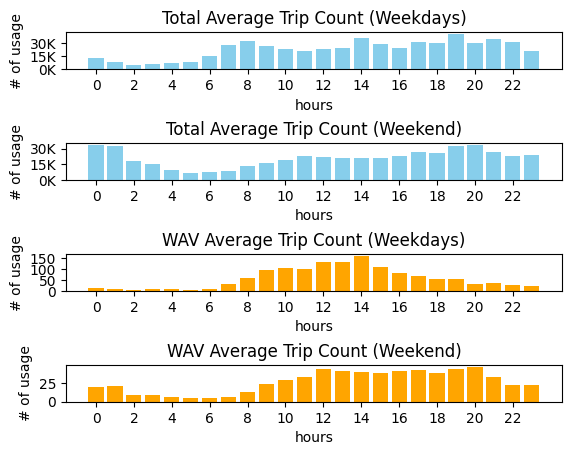

In [44]:
datas = [df_weekdays_gb, df_weekend_gb, wav_df_weekdays_gb, wav_df_weekend_gb]
titles = ["Total Average Trip Count (Weekdays)", "Total Average Trip Count (Weekend)",
          "WAV Average Trip Count (Weekdays)", "WAV Average Trip Count (Weekend)",]
intervals = [15000, 15000, 50, 25]
colors = ['skyblue', 'skyblue', 'orange', 'orange']

for i in range(len(datas)):
    data_df = ps.DataFrame(datas[i])
    np_data = data_df.to_numpy()
    hours = list(np_data[:,0])
    cnt = list(np_data[:,2])
    max_cnt = int(max(cnt))
    
    plt.subplot(4,1,i+1)    
    plt.bar(hours, cnt, color=colors[i])
    plt.xlabel("hours")
    plt.ylabel("# of usage")
    plt.xticks([x for x in range(0, 24, 2)])
    y_interval = intervals[i]
    if y_interval > 1000:
        y_ticks_str = [str(x//1000)+ "K" for x in range(0, max_cnt, y_interval)]
    else:
        y_ticks_str = [str(x) for x in range(0, max_cnt, y_interval)]
    plt.yticks([y for y in range(0, max_cnt, y_interval)], y_ticks_str)
    plt.title(titles[i])

plt.subplots_adjust(hspace=2, wspace=0.7)
plt.show()

# Insights from TLC Dataset
1. 평일/주말 여부에 따른 차량 호출수를 비교해 보았을 때, 전체 호출에 대한 수요를 확인했을 때는 평균적으로 평일보다 주말에 높은 수요가 존재하지만, WAV 차량을 요구한 요청만을 확인했을 때는 평균적으로 주말보다 평일에 더욱 높은 호출량을 확인할 수 있다. 
2. 시간에 따른 차량 호출수를 비교해 보았을 때, 전체 차량 호출수와 WAV 차량 호출수 모두 평일보다 주말에 늦은 시간대(21~2)의 호출량이 월등히 높다.